In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import attention_conv.ae as ae
import imp
from main_dataset import SingleCropGenerator
from image_set import ImageSet
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
imp.reload(ae)
ModelToTest = ae.AE
params = []

Setup dataset and dataloader

In [4]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
# dataset = CHMainDataset(np_set, gen)
dataset = ImageSet(np_set, gen)

Training Setup

In [5]:
BATCH_LEN = 16 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [5]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

NameError: name 'dataset' is not defined

In [6]:
model = ModelToTest()

Training utilities
# wow

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

NameError: name 'model' is not defined

Training loop definition

In [6]:
dir_to_save = 'attnconv_ae'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [7]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch):
    its_til_checkpoint = 20
    its_til_update = 1
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)
        
#         print(predictions.shape, targets.shape)
        loss = criterion(predictions, targets.unsqueeze(1))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
            
        if i == 120: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [21]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'cl_loader' is not defined

In [8]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch)
        print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
        plt.plot(epoch_losses, 'r-')
        plt.title('Epoch Losses')
        plt.show()
    
    return losses

In [7]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = ImageSet(np_set, gen)
dataset[0][1].shape

(128, 128)

In [9]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ModelToTest()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
msssim = MS_SSIMLoss(channels=1)
l1 = torch.nn.L1Loss()
mse = torch.nn.MSELoss()
criterion = lambda pred, target: msssim(pred,target) #msssim(pred,target) #+ l1(pred,target) 

In [63]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

Entering epoch 0
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16


KeyboardInterrupt: 

In [24]:
torch.save(model.encoder.state_dict(), os.path.join(dir_to_save, 'encoder_best'))
torch.save(model.decoder.state_dict(), os.path.join(dir_to_save, 'decoder_best'))

In [64]:
model.encoder.load_state_dict(torch.load('attnconv_ae/encoder_decoder_best/encoder_best', map_location=device))
model.decoder.load_state_dict(torch.load('attnconv_ae/encoder_decoder_best/decoder_best', map_location=device))

<All keys matched successfully>

#### Lets see the results


torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0270)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0406)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0725)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0092)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0266)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0925)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0258)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0619)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0138)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0129)


/opt/conda/envs/main-torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/opt/conda/envs/main-torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0499)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0361)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0079)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0136)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0472)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0136)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0099)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0122)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0553)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0122)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0746)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0116)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0204)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0093)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0141)
torch.Size([128, 128]) torch.Size([128, 128])
tensor(0.0092)
torch.Size([128, 128]) t

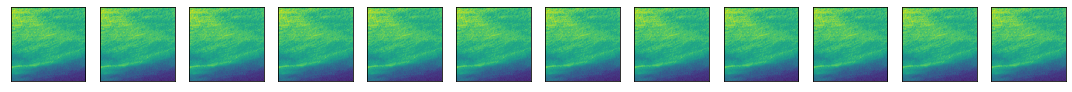

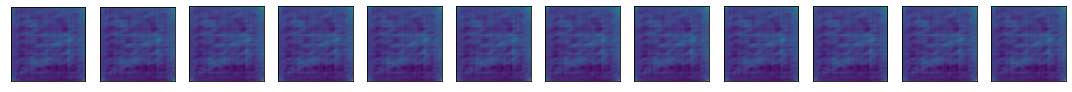

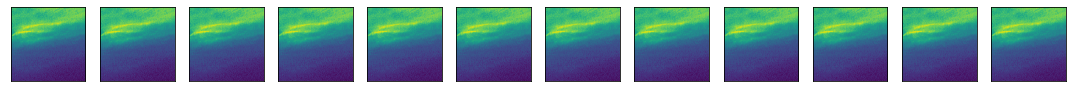

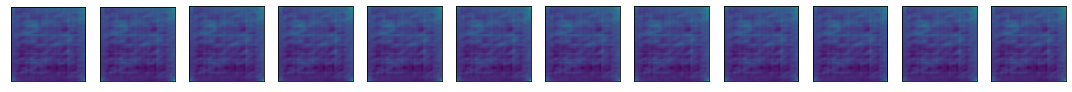

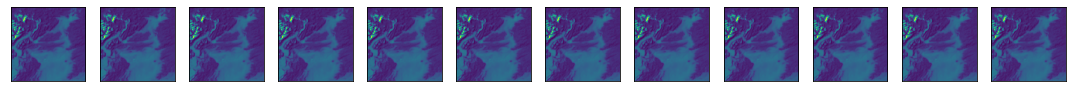

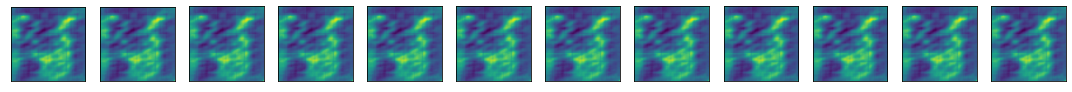

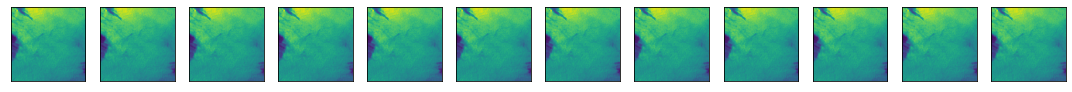

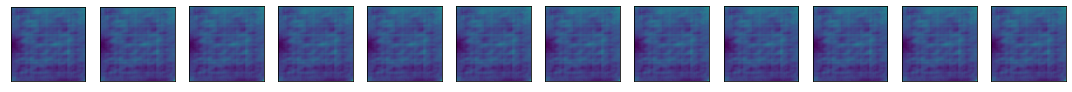

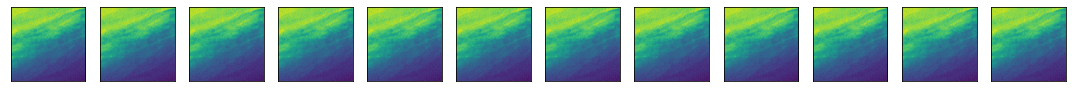

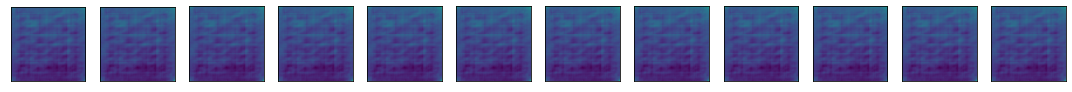

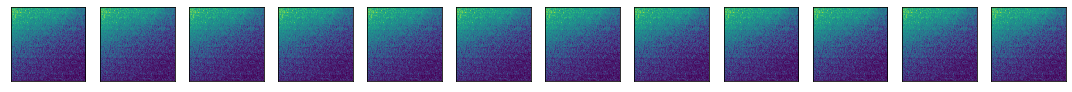

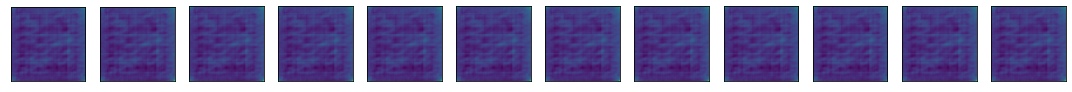

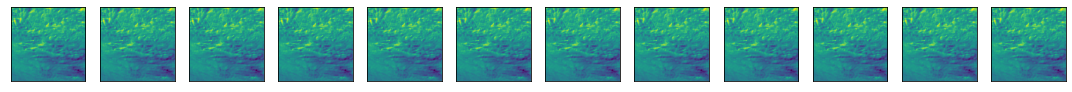

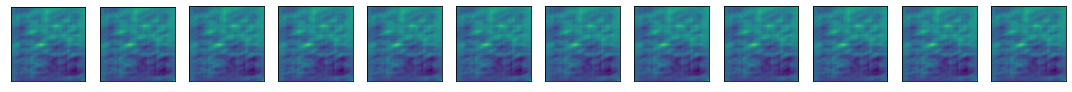

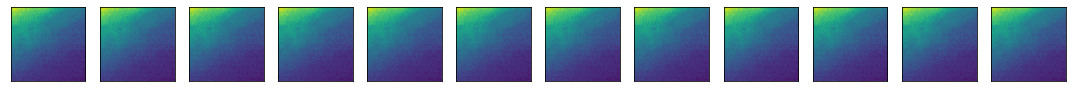

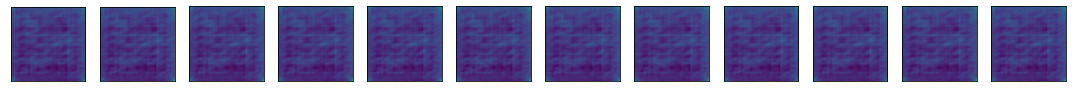

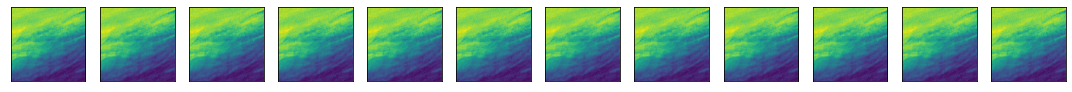

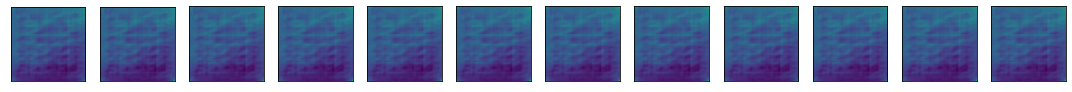

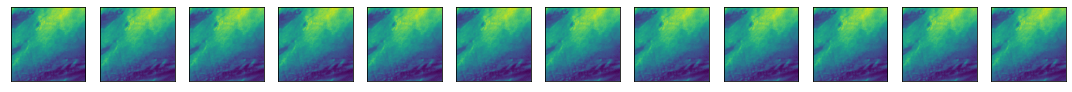

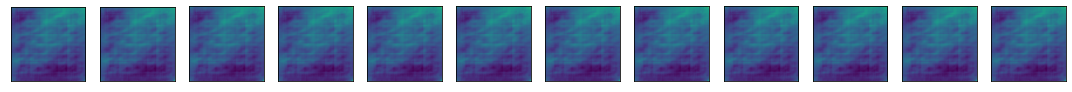

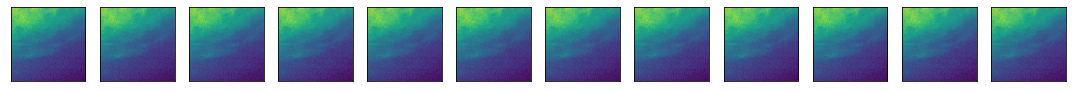

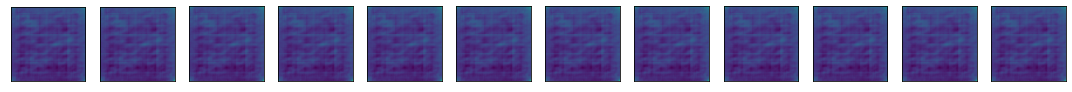

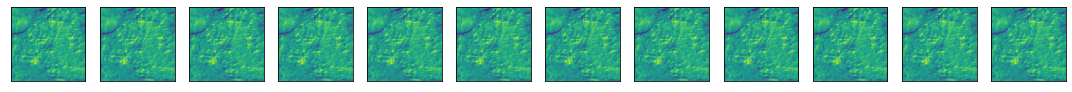

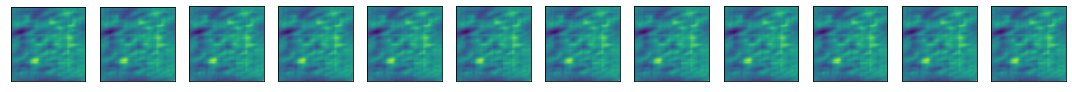

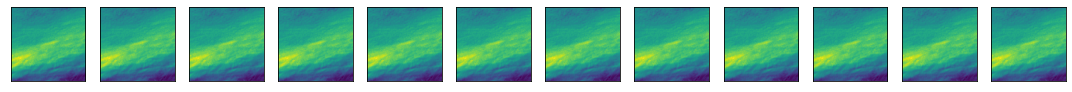

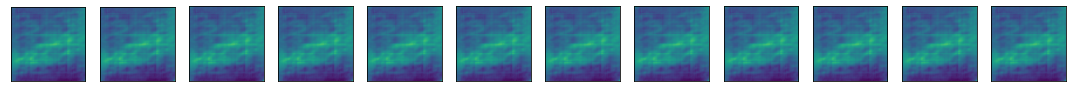

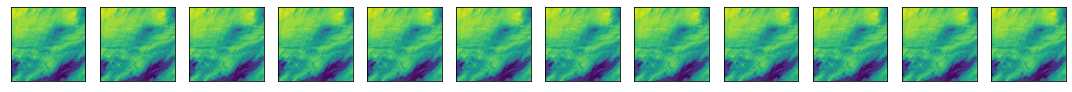

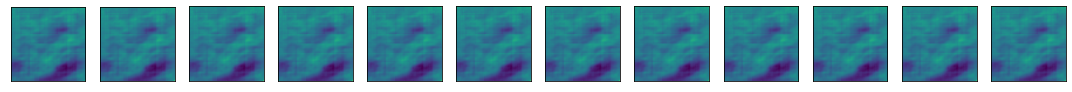

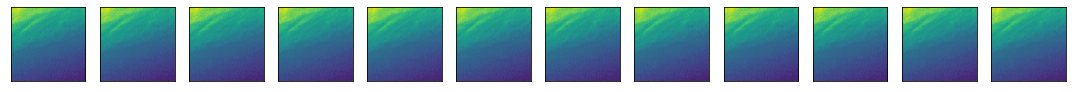

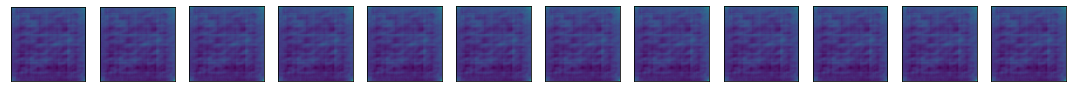

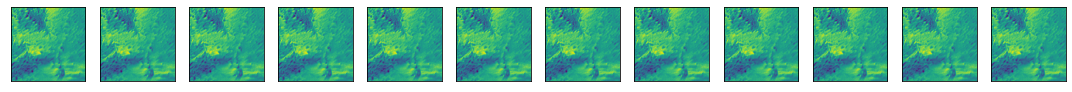

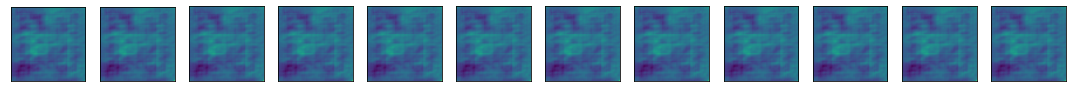

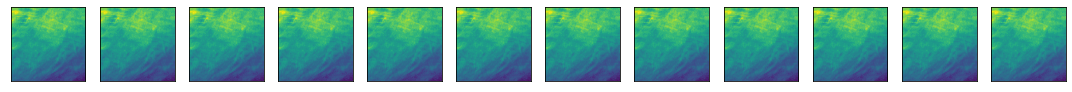

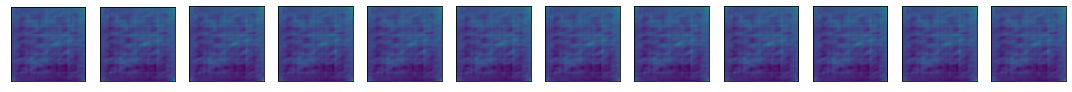

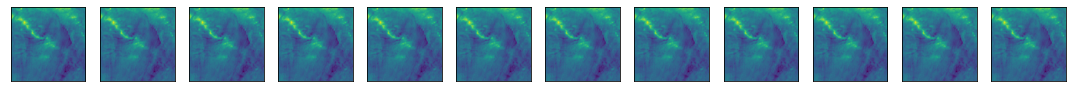

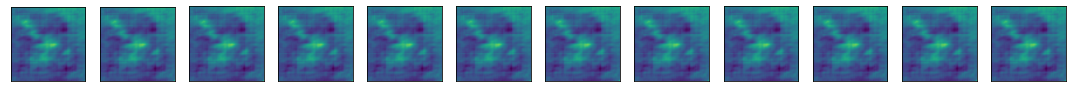

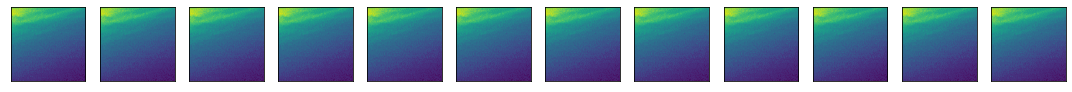

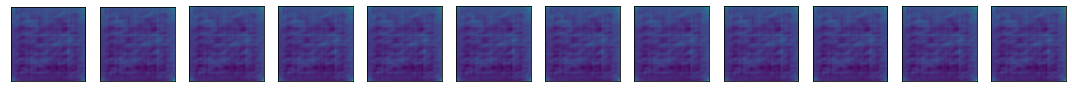

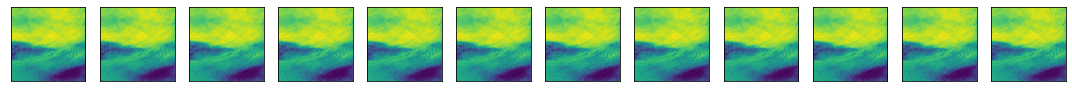

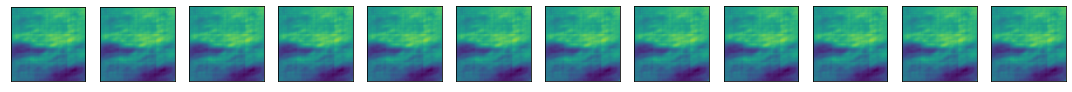

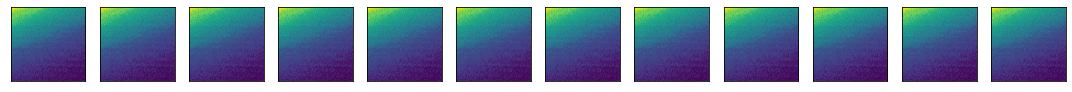

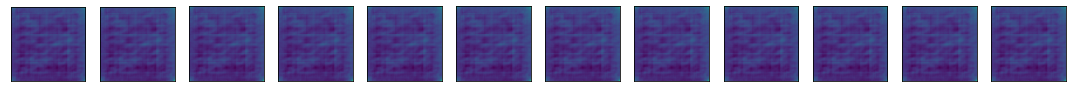

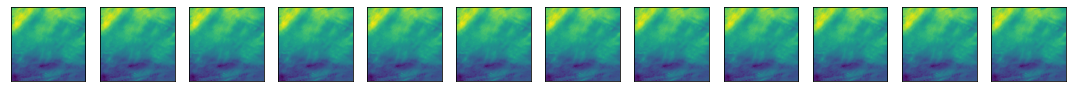

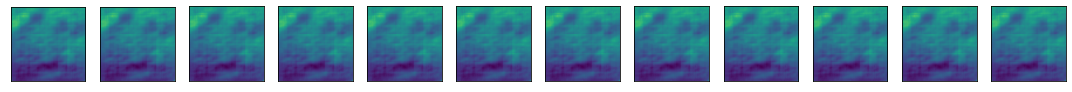

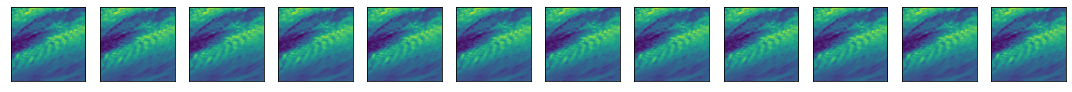

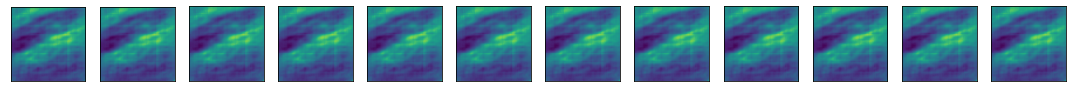

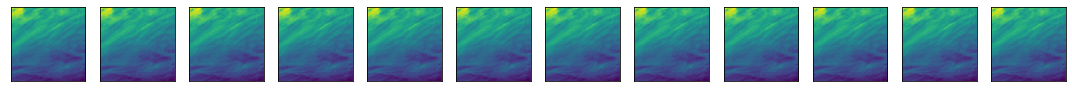

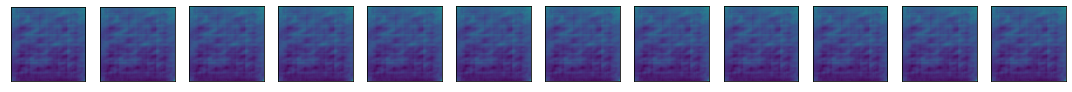

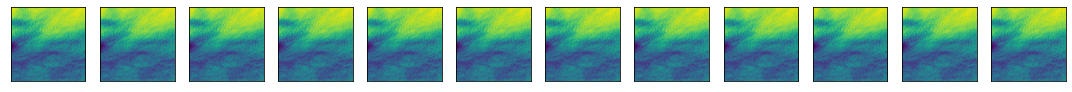

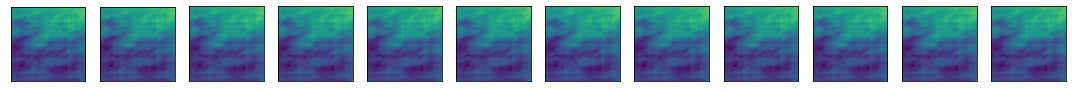

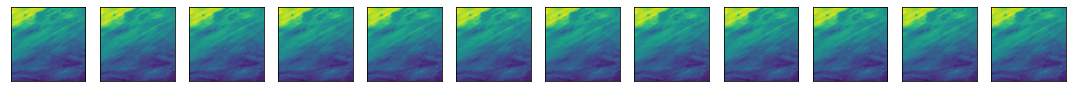

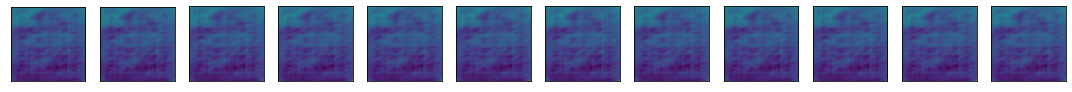

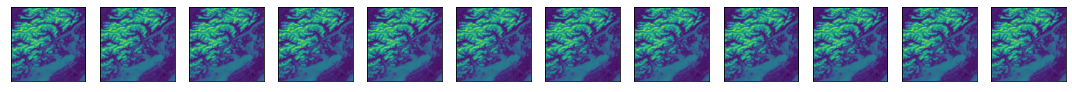

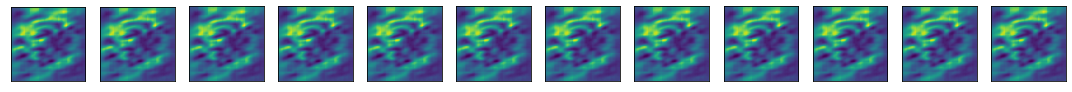

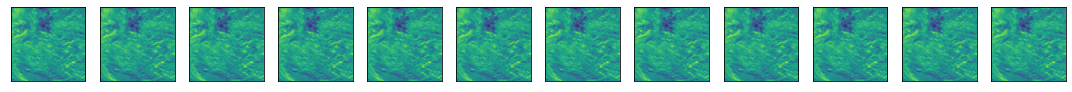

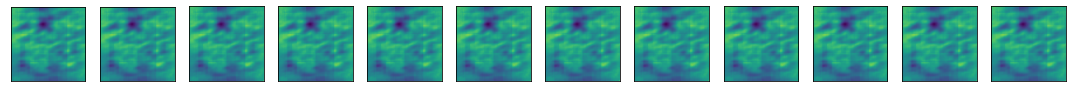

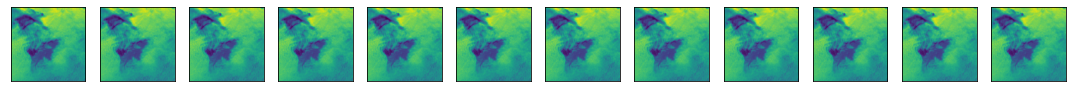

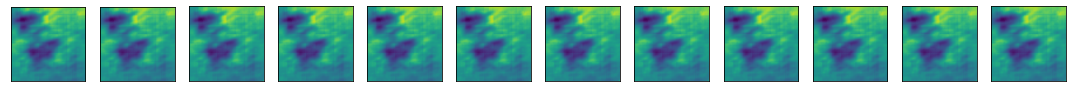

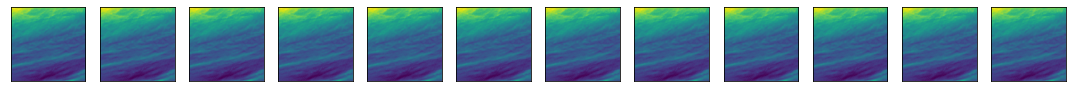

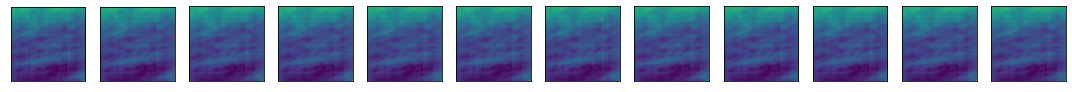

In [11]:
model.eval()
garbo = [dataset[i] for i in range(10, 40)]
for i, (features, targets) in enumerate(garbo):
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features, cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(1, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for ax in axs:
        ax.imshow(predictions, cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        #print(predictions[p_no])
        p_no += 1
    fig.tight_layout()
    
    for feature in features:
        print(predictions.shape, feature.shape)
        print(msssim(predictions.view([1,1,128,128]).type(torch.FloatTensor),feature.view([1,1,128,128]).type(torch.FloatTensor)))
    
    fig.show()

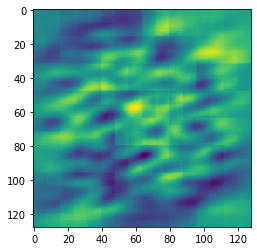

tensor(8.9988)
tensor(-0.9999)


In [62]:
latent = torch.rand([1, 4096, 1, 1]) * 10 - 1
garbage = model.decoder(latent)
plt.imshow(garbage.detach().squeeze(), cmap='viridis')
plt.show()
print(torch.max(latent))
print(torch.min(latent))

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()